In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'
import matplotlib.colors as colors
import cmocean.cm as cmo
from glob import glob
from xorca.lib import load_xorca_dataset
import xgcm

In [2]:
import datetime

### test with 4 years of data to see if it runs smoothly

In [3]:
KE_data_filesREF = sorted(glob("/data0/project/drakkar/USERS/jrieck/CREG12.L75-REF08-KE/????/CREG12.L75-REF08_*.5d_KE.nc"))
KE_data_filesFUT = sorted(glob("/data0/project/drakkar/USERS/jrieck/CREG12.L75-FUT08-KE/????/CREG12.L75-FUT08_*.5d_KE.nc"))
grid_files = ["/data0/project/drakkar/CONFIGS/CREG12.L75/GRID/CREG12.L75-REF08_mask.nc", 
              "/data0/project/drakkar/CONFIGS/CREG12.L75/GRID/CREG12.L75-REF08_mesh_hgr.nc",
              "/data0/project/drakkar/CONFIGS/CREG12.L75/GRID/CREG12.L75-REF08_mesh_zgr.nc"]
coords_file = "/data0/project/drakkar/CONFIGS/CREG12.L75/GRID/coordinates_CREG12_lbclnk_noz_vh20160930.nc"
bathy_file = "/data0/project/drakkar/CONFIGS/CREG12.L75/GRID/bathymetry_CREG12_V3.3_CT20180612Larger_ct20190102.nc"

In [4]:
def prepro(ds):
    return ds.isel(y=slice(800, None))

In [5]:
grid = xr.open_mfdataset(grid_files, parallel=True, preprocess=prepro)
coords = xr.open_mfdataset(coords_file, parallel=True, preprocess=prepro)
bathy = xr.open_mfdataset(bathy_file, parallel=True, preprocess=prepro)

In [6]:
KEREF = xr.decode_cf(xr.open_mfdataset(KE_data_filesREF, coords="minimal", compat="override", parallel=True, decode_cf=False,
                                       preprocess=prepro, chunks={"deptht": 1, "y": 600, "x": 800}))

In [7]:
KEFUT = xr.decode_cf(xr.open_mfdataset(KE_data_filesFUT, coords="minimal", compat="override", parallel=True, decode_cf=False,
                                       preprocess=prepro, chunks={"deptht": 1, "y": 600, "x": 800}))

In [8]:
moorx = [540, 820, 960, 650, 1040, 840, 870, 1200, 660, 540, 1080, 1070]
moory = [1530, 1250, 1150, 1220, 1320, 1540, 1660, 1000, 1550, 1620, 1460, 1400]
moorn = ["001", "002", "003", "004", "005", "006", "007", "008", "009", "WAL", "WLS", "WSZ"]

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

(bathy.Bathymetry.where(bathy.Bathymetry!=0, other=6000)).plot(ax=ax[0], cmap=cmo.deep, vmin=0, vmax=5000)

KEREF.voke.where(KEREF.voke != 0).isel(deptht=0).mean("time_counter").plot(vmin=1e-5, vmax=1e-1, cmap=cmo.deep_r, norm=colors.LogNorm(), ax=ax[1])
KEFUT.voke.where(KEFUT.voke != 0).isel(deptht=0).mean("time_counter").plot(vmin=1e-5, vmax=1e-1, cmap=cmo.deep_r, norm=colors.LogNorm(), ax=ax[2])
ax[1].text(100, 800, "REF\nKE\n\n2000-2009")
ax[2].text(100, 800, "FUT\nKE\n\n2060-2069")

for a in ax:
    for i in range(0, len(moorn)):
        a.plot(moorx[i], moory[i] - 800, marker="o", color="firebrick")
        a.annotate(moorn[i].strip("0"), (moorx[i], moory[i] - 800), textcoords="offset points", xytext=(3, -10), ha='left', color="firebrick")

#plt.savefig("figures/CREG12.L75_KE_REF08_2000-2009_vs_FUT08_2060-2069_k00_moorings_bathy.v2.png", dpi=300)

In [9]:
ks = [0, 23, 30, 39, 50]
vmins = {}
vmaxs = {}
vmins[ks[0]] = 1e-5
vmaxs[ks[0]] = 5e-2
vmins[ks[1]] = 1e-5
vmaxs[ks[1]] = 5e-2
vmins[ks[2]] = 5e-6
vmaxs[ks[2]] = 1e-2
vmins[ks[3]] = 1e-6
vmaxs[ks[3]] = 5e-3
vmins[ks[4]] = 5e-7
vmaxs[ks[4]] = 1e-3

<Figure size 640x480 with 0 Axes>

<Figure size 1300x1500 with 0 Axes>

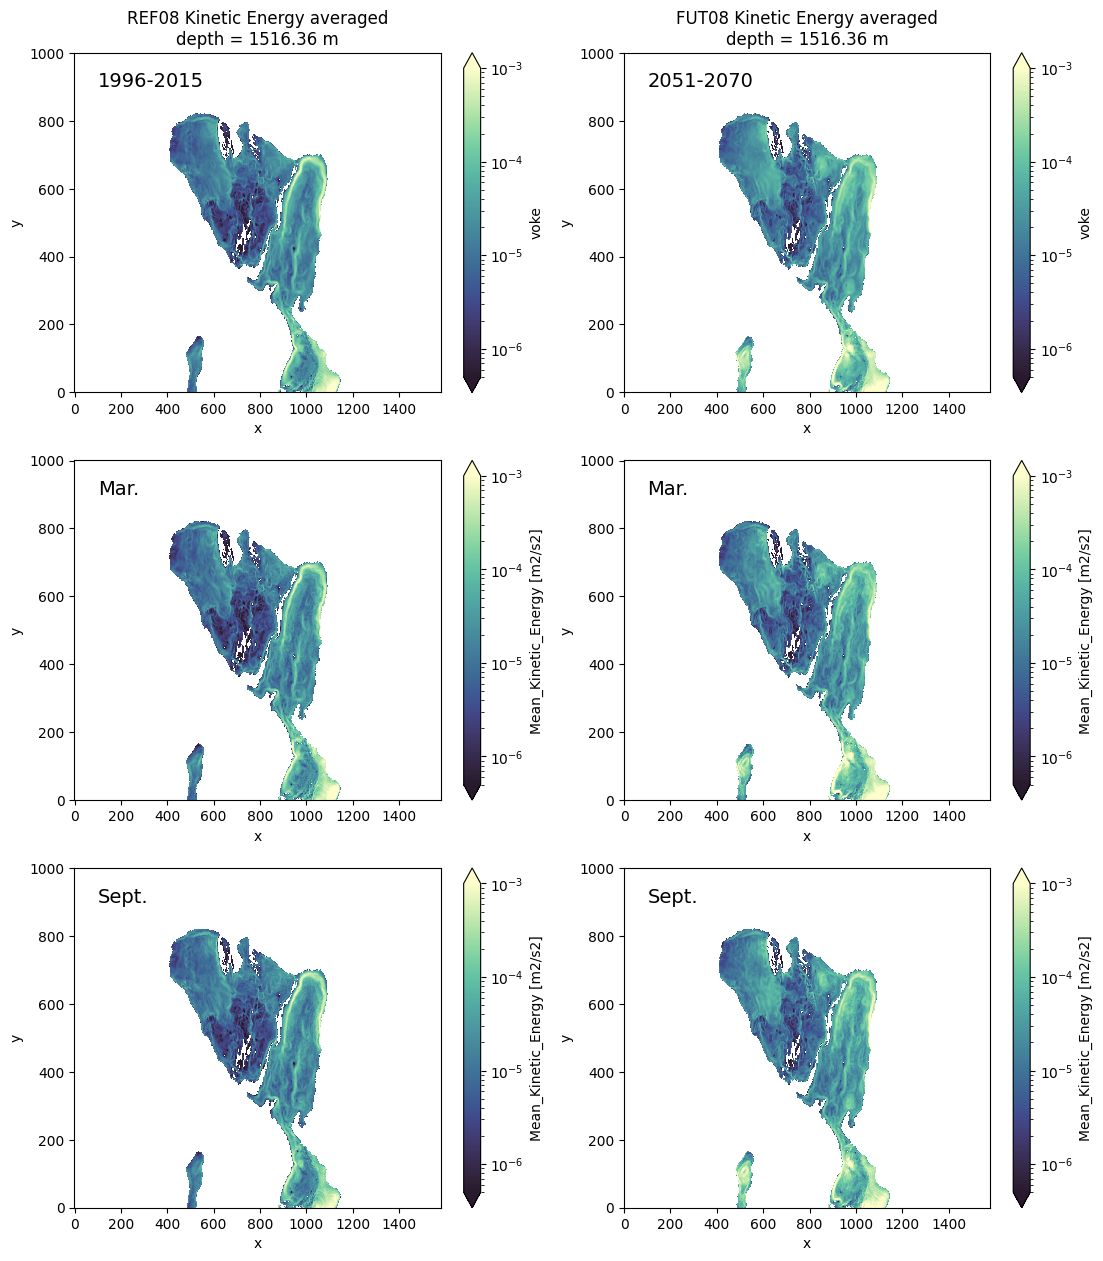

In [10]:
for k in ks[3:5]:
    vmin = vmins[k]
    vmax = vmaxs[k]
    plt.clf()
    fig, ax = plt.subplots(3, 2, figsize=(13, 15))
    KEREF.isel(deptht=k).voke.where(KEREF.isel(deptht=k).voke > 0).mean("time_counter").plot(vmin=vmin, vmax=vmax, 
                                                                                              cmap=cmo.deep_r, norm=colors.LogNorm(), ax=ax[0, 0])
    KEFUT.isel(deptht=k).voke.where(KEFUT.isel(deptht=k).voke > 0).mean("time_counter").plot(vmin=vmin, vmax=vmax, 
                                                                                              cmap=cmo.deep_r, norm=colors.LogNorm(), ax=ax[0, 1])
    ax[0, 0].text(100, 900, "1996-2015", fontsize=14)
    ax[0, 1].text(100, 900, "2051-2070", fontsize=14)
    ax[0, 0].set_title("REF08 Kinetic Energy averaged\ndepth = " + str(np.around(KEREF.deptht[k].values, decimals=2)) + " m")
    ax[0, 1].set_title("FUT08 Kinetic Energy averaged\ndepth = " + str(np.around(KEFUT.deptht[k].values, decimals=2)) + " m")
    KEREF.isel(deptht=k).voke.where(KEREF.isel(deptht=k).voke > 0).groupby("time_counter.month").mean("time_counter").sel(month=3).plot(vmin=vmin, vmax=vmax,
                                                                                              cmap=cmo.deep_r, norm=colors.LogNorm(), ax=ax[1, 0])
    KEFUT.isel(deptht=k).voke.where(KEFUT.isel(deptht=k).voke > 0).groupby("time_counter.month").mean("time_counter").sel(month=3).plot(vmin=vmin, vmax=vmax, 
                                                                                              cmap=cmo.deep_r, norm=colors.LogNorm(), ax=ax[1, 1])
    ax[1, 0].text(100, 900, "Mar.", fontsize=14)
    ax[1, 1].text(100, 900, "Mar.", fontsize=14)
    ax[1, 0].set_title("")
    ax[1, 1].set_title("")
    KEREF.isel(deptht=k).voke.where(KEREF.isel(deptht=k).voke > 0).groupby("time_counter.month").mean("time_counter").sel(month=9).plot(vmin=vmin, vmax=vmax,
                                                                                              cmap=cmo.deep_r, norm=colors.LogNorm(), ax=ax[2, 0])
    KEFUT.isel(deptht=k).voke.where(KEFUT.isel(deptht=k).voke > 0).groupby("time_counter.month").mean("time_counter").sel(month=9).plot(vmin=vmin, vmax=vmax, 
                                                                                              cmap=cmo.deep_r, norm=colors.LogNorm(), ax=ax[2, 1])
    ax[2, 0].text(100, 900, "Sept.", fontsize=14)
    ax[2, 1].text(100, 900, "Sept.", fontsize=14)
    ax[2, 0].set_title("")
    ax[2, 1].set_title("")
    plt.savefig("../figures/CREG12.L75_KE_REF08_1996-2015_vs_FUT08_2051-2070_k" + f'{k:02}' + "_annual-mar-sep.png", dpi=300)